# Giới thiệu
- Tạo mô hình để phân biệt giọng nói của 3 vùng miền Việt Nam (Bắc, Trung, Nam) từ biểu diễn miền tần số của bản ghi âm giọng nói, thu được thông qua Fast Fourier Transform (FFT).
- Chúng ta sẽ biết được:
  + Cách sử dụng tf.data để tải, xử lý trước và cấp luồng âm thanh vào một mô hình.
  + Cách tạo mạng chập 1D với các kết nối còn lại để phân loại âm thanh.

- Quá trình:
  + Chuẩn bị một tập dữ liệu về các lời nói của 3 miền khác nhau.
  + Thêm tiếng ồn xung quanh vào các mẫu này để tăng cường độ thực tế, chính xác của dữ liệu.
  + Lấy FFT của những mẫu này.
  + Đào tạo dữ liệu với mô hình CNN.

In [1]:
import os # ĐỌC FILES TRONG FOLDER 
import shutil # COPY FILES, FOLDERS
import numpy as np

import tensorflow as tf # ĐỌC, GIẢI MÃ FILE AUDIO
from tensorflow import keras

from pathlib import Path
from IPython.display import display, Audio

import soundfile as sf  # GHI FILE AUDIO 
import librosa  # ĐỌC FILE AUDIO 
from sklearn.metrics import mean_squared_error

In [2]:
# ĐƯỜNG DẪN THƯ MỤC CHỨA DATASET (BAN ĐẦU)
DATASET_ROOT = '/content/drive/MyDrive/XLDLL/dataset/init'

# ĐƯỜNG DẪN THƯ MỤC CHỨA DATASET (ĐÃ XỬ LÝ)
HANDLED_DATASET_ROOT = '/content/drive/MyDrive/XLDLL/dataset/handled'

AUDIO_SUBFOLDER = "audio"

NOISE_SUBFOLDER = "noise"

# ĐƯỜNG DẪN THƯ MỤC audio
DATASET_AUDIO_PATH = os.path.join(HANDLED_DATASET_ROOT, AUDIO_SUBFOLDER)

# ĐƯỜNG DẪN THƯ MỤC noise
DATASET_NOISE_PATH = os.path.join(HANDLED_DATASET_ROOT, NOISE_SUBFOLDER)

VALID_SPLIT = 0.2       # LẤY TẬP TEST TỪ TẬP TRAIN VỚI TỶ LỆ LÀ 0.2

SHUFFLE_SEED = 42       # DÙNG ĐỂ XÁO TRỘN DỮ LIỆU

SAMPLING_RATE = 16000   # TỶ LỆ MẪU: 16000 Hz

SCALE = 0.5             # HỆ SỐ NHÂN NHIỄU

BATCH_SIZE = 128        # SỐ LƯỢNG MẪU DỮ LIỆU TRONG MỘT LẦN HUẤN LUYỆN

EPOCHS = 100            # SỐ LẦN DUYỆT QUA HẾT CÁC DỮ LIỆU TRONG TẬP HUẤN LUYỆN

In [ ]:
# COPY FILES TỪ THƯ MỤC DATASET BAN ĐẦU SANG THƯ MỤC MỚI -> THAO TÁC VỚI DỮ LIỆU
shutil.copytree(DATASET_ROOT, HANDLED_DATASET_ROOT)

'/content/drive/MyDrive/XLDLL/dataset/handled'

# Xử lý dữ liệu tiếng ồn (Noise)
- Lấy tất cả các mẫu tiếng ồn.
- Chuyển các mẫu tiếng ồn này về sample rate = 16000 Hz.
- Chia các mẫu tiếng ồn đó thành các mẫu tương ứng có độ dài 1 giây.

In [3]:
# FUNCTION GIẢM TẦN SỐ ÂM THANH VỀ 16000 HZ
def convertToSampleRate16KHz(filepath, sampling_rate):
    data, fs = librosa.load(filepath, sr=sampling_rate) # ĐỌC FILE
    data = np.array(data*32767, dtype='int16')          # CONVERT DATA SANG INT16 [-32,768 to 32,767]
    sf.write(filepath, data, sampling_rate)             # GHI LẠI FILE VỚI SAMPLING RATE = 16000 Hz

In [4]:
# LẤY DANH SÁCH ĐƯỜNG DẪN CỦA CÁC FILE NOISE AUDIO
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

print(
    "Tìm thấy {} tệp .wav trong {} thư mục".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH)))
    )

Tìm thấy 6 tệp .wav trong 2 thư mục


In [5]:
noise_paths

['/content/drive/MyDrive/XLDLL/dataset/handled/noise/other/pink_noise.wav',
 '/content/drive/MyDrive/XLDLL/dataset/handled/noise/other/exercise_bike.wav',
 '/content/drive/MyDrive/XLDLL/dataset/handled/noise/background_noise/dude_miaowing.wav',
 '/content/drive/MyDrive/XLDLL/dataset/handled/noise/background_noise/10convert.com_Audience-Claps_daSG5fwdA7o.wav',
 '/content/drive/MyDrive/XLDLL/dataset/handled/noise/background_noise/running_tap.wav',
 '/content/drive/MyDrive/XLDLL/dataset/handled/noise/background_noise/doing_the_dishes.wav']

In [6]:
# CHUYỂN TẦN SỐ ÂM THANH CỦA CÁC TỆP ÂM THANH ỒN VỀ 16000 HZ 
for filepath in noise_paths:
    convertToSampleRate16KHz(filepath, SAMPLING_RATE)

In [7]:
# CHIA NHỎ CÁC TỆP TIN TIẾNG ỒN THÀNH CÁC TẬP TIN CÓ ĐỘ DÀI 1S 
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None

# LƯU TRỮ CÁC NOISES 
noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "Có {} tệp noise đã được phân chia thành {} mẫu noise có độ dài {} giây.".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

Có 6 tệp noise đã được phân chia thành 354 mẫu noise có độ dài 1 giây.


# Tạo ra tập dữ liệu dùng để train và validate 
- Lấy danh sách các file audio cùng với nhãn tương ứng.
- Chuyển các tệp âm thanh về dạng sample rate 16000 hz
- Xáo trộn danh sách file.
- Chia danh sách file ra 2 phần: train và validation với tỷ lệ validation là 0.2.
- Tạo 2 tập dữ liệu từ 2 danh sách file (train, validation) ở trên.
- Thêm các âm thanh noise vào tập dữ liệu dùng để train.
- Chuyển đổi sóng audio của tập training, validation thành phổ tần số (âm phổ !!!)

In [8]:
# FUNCTION TẠO RA TẬP CHỨA AUDIOS VÀ LABELS
def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


# FUNCTION ĐỌC VÀ DECODE (GIẢI MÃ) FILE AUDIO
def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


# FUNCTION DÙNG ĐỂ THÊM NOISE VÀO TẬP DỮ LIỆU DÙNG ĐỂ TRAIN
def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from -> # TẠO RA MỘT NOISE CÓ CÙNG KÍCH THƯỚC VỚI AUDIO BAN ĐẦU
        # 0 to the number of noise stream samples that we have.
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Get the amplitude proportion between the audio and the noise -> TỶ LỆ BIÊN ĐỘ GIỮA AUDIO VÀ NOISE
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio -> THÊM NOISE ĐÃ THAY ĐỔI TỶ LỆ BIÊN ĐỘ VÀO FILE AUDIO
        audio = audio + noise * prop * scale

    return audio


# FUNCTION CHUYỂN ĐỔI SÓNG AUDIO THÀNH ÂM PHỔ (SPECTRUM) THÔNG QUA FAST FOURIER TRANSFORM (FFT)
def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    # LẤY ÂM PHỔ CỦA AUDIO 
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    # TRẢ VỀ GIÁ TRỊ TUYỆT ĐỐI ĐẠI DIỆN CHO TẦN SỐ DƯƠNG
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])

In [9]:
# Get the list of audio file paths along with their corresponding labels
# LẤY DANH SÁCH CÁC ĐƯỜNG DẪN FILE AUDIO CÙNG VỚI LABEL TƯƠNG ỨNG
class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    # print("Processing speaker {}".format(name,))
    print(">>> Label: ", label)
    print(">>> Name: ", name)
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print("Tìm thấy {} tệp thuộc {} lớp.".format(len(audio_paths), len(class_names)))

Our class names: ['trung', 'nam', 'bắc']
>>> Label:  0
>>> Name:  trung
>>> Label:  1
>>> Name:  nam
>>> Label:  2
>>> Name:  bắc
Tìm thấy 623 tệp thuộc 3 lớp.


In [10]:
print(">>> audio paths: ", audio_paths)
print(">>> labels: ", labels)

>>> audio paths:  ['/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/153.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/152.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/147.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/149.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/145.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/146.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/15.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/144.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/148.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/151.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/150.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/143.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/140.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/142.wav', '/content/drive/MyDrive/XLDLL/

In [11]:
# CHUYỂN TẦN SỐ ÂM THANH CỦA CÁC TỆP TIN ÂM THANH VỀ 16000 HZ 
for filepath in audio_paths:
    convertToSampleRate16KHz(filepath, SAMPLING_RATE)

In [12]:
# Shuffle
# XÁO TRỘN DANH SÁCH CÁC ĐƯỜNG DẪN FILE 
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

In [13]:
# Split into training and validate
# CHIA RA 2 PHẦN DÙNG ĐỂ TRAIN VÀ VALIDATE 
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validate.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

Using 499 files for training.
Using 124 files for validate.


In [14]:
print(train_audio_paths)
print(train_labels)

['/content/drive/MyDrive/XLDLL/dataset/handled/audio/nam/134.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/bắc/196.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/209.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/nam/108.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/161.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/88.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/40.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/45.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/bắc/185.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/234.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/nam/140.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/nam/91.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/96.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/106.wav', '/content/drive/MyDrive/XLDLL/dataset/handled/audio/trung/14

In [15]:
# Create 2 datasets, one for training and the other for validate
# TẠO 2 TẬP DỮ LIỆU TRAINING VÀ VALIDATION TỪ 2 DANH SÁCH FILE Ở TRÊN -> DÙNG FUNCTION paths_and_labels_to_dataset()
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(BATCH_SIZE)

In [17]:
y = np.concatenate([x for x, y in train_ds], axis=0)
print("Dữ liệu train ban đầu: ", y)
# print(tf.squeeze(y[0], axis=-1))

Dữ liệu train ban đầu:  [[[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.00466919]
  [ 0.00384521]
  [ 0.00064087]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.02337646]
  [ 0.00634766]
  [-0.00881958]]

 [[-0.00027466]
  [-0.00042725]
  [-0.00036621]
  ...
  [ 0.06707764]
  [ 0.06845093]
  [ 0.06726074]]

 ...

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.00894165]
  [ 0.01043701]
  [ 0.01663208]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.02050781]
  [ 0.01074219]
  [ 0.        ]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [ 0.04223633]
  [ 0.13043213]
  [ 0.19052124]]]


In [19]:
# Add noise to the training set
# THÊM NOISE VÀO TẬP DỮ LIỆU TRAINING 
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# THÊM NOISE VÀO TẬP DỮ LIỆU VALIDATION 
valid_ds = valid_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

In [20]:
# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

In [21]:
train_audio_fft = np.concatenate([x for x, y in train_ds], axis=0)
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(">>> Dữ liệu train sau khi đã xử lý")
print("Audio: ", train_audio_fft)
print("Label: ", train_label)

>>> Dữ liệu train sau khi đã xử lý
Audio:  [[[2.58638334e+00]
  [6.76406741e-01]
  [1.03628945e+00]
  ...
  [1.66558564e-01]
  [1.64537326e-01]
  [1.55174643e-01]]

 [[1.03787336e+01]
  [2.97565651e+00]
  [1.95582998e+00]
  ...
  [5.93600571e-02]
  [5.36265969e-02]
  [2.09223405e-01]]

 [[1.73573077e+00]
  [2.21457410e+00]
  [2.44985938e+00]
  ...
  [1.30408332e-01]
  [2.22922936e-01]
  [2.99026012e-01]]

 ...

 [[1.01272327e+03]
  [3.69835480e+02]
  [1.54762131e+02]
  ...
  [9.26269740e-02]
  [1.34616211e-01]
  [9.65653285e-02]]

 [[2.61454296e+00]
  [3.54722291e-01]
  [2.16681361e+00]
  ...
  [1.48604557e-01]
  [4.09696139e-02]
  [4.10651341e-02]]

 [[2.75935486e+02]
  [2.66661316e+02]
  [1.73845612e+02]
  ...
  [2.95702927e-02]
  [4.45893072e-02]
  [3.31406221e-02]]]
Label:  [1 1 2 2 2 0 2 2 2 0 1 2 2 1 2 2 2 2 0 0 1 1 0 1 2 1 2 1 1 2 0 2 2 0 2 0 2
 1 2 1 2 0 2 2 0 0 0 2 0 0 2 0 1 2 1 0 2 0 0 2 2 2 0 0 0 1 1 2 1 1 2 2 0 0
 2 0 0 1 0 2 0 2 0 0 1 2 2 0 1 2 0 2 2 2 2 0 2 1 1 0 1 1 0 1 

# Khởi tạo mô hình (model)

In [ ]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# THUẬT TOÁN TỐI ƯU ADAM, HÀM LOSS SPARSE_CATEGORICAL_CROSSENTROPY, ĐỘ ĐO ACCURACY 
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping': NGƯNG HUẤN LUYỆN KHI MÔ HÌNH KHÔNG ĐƯỢC CẢI THIỆN
# 'ModelCheckPoint': LUÔN GIỮ CHO MÔ HÌNH CÓ ĐỘ CHÍNH XÁC TỐT NHẤT 
model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 8000, 1)]    0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 8000, 16)     64          ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, 8000, 16)     0           ['conv1d_1[0][0]']               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 8000, 16)     784         ['activation[0][0]']             
                                                                                              

# Đào tạo mô hình (train model)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/100
4/4 [==============================] - 42s 8s/step - loss: 3.7375 - accuracy: 0.4128 - val_loss: 1.0577 - val_accuracy: 0.3871
Epoch 2/100
4/4 [==============================] - 37s 8s/step - loss: 0.9697 - accuracy: 0.5351 - val_loss: 0.7770 - val_accuracy: 0.6371
Epoch 3/100
4/4 [==============================] - 37s 8s/step - loss: 0.7173 - accuracy: 0.6733 - val_loss: 0.5399 - val_accuracy: 0.7742
Epoch 4/100
4/4 [==============================] - 36s 8s/step - loss: 0.6552 - accuracy: 0.7234 - val_loss: 0.4113 - val_accuracy: 0.8306
Epoch 5/100
4/4 [==============================] - 36s 8s/step - loss: 0.4844 - accuracy: 0.8036 - val_loss: 0.4910 - val_accuracy: 0.7661
Epoch 6/100
4/4 [==============================] - 36s 8s/step - loss: 0.4787 - accuracy: 0.7956 - val_loss: 0.3726 - val_accuracy: 0.8710
Epoch 7/100
4/4 [==============================] - 36s 8s/step - loss: 0.4119 - accuracy: 0.8216 - val_loss: 0.2969 - val_accuracy: 0.8952
Epoch 8/100
4/4 [==========

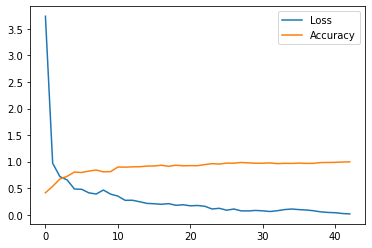

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.legend()
plt.show()

# Đánh giá mô hình trên tập validation

In [ ]:
# ĐÁNH GIÁ MÔ HÌNH VỚI TẬP VALIDATION 
print(model.evaluate(valid_ds))

# test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))
for audios, labels in valid_ds.take(1):
    y_pred = model.predict(audios)

a = np.array([])

for i in range(y_pred.shape[0]):
  max = np.max(y_pred[i])
  index = np.where(y_pred[i] == max)[0][0]
  a = np.append(a, index)

rmse = mean_squared_error(np.array(labels), a, squared=False)
print("RMSE: ", rmse)

# example: y_pred[0] = [0.2, 0.6, 0.2] => pred_label = label(1) = nam/trung/bac
# y_pred.shape = (499, 3)

1/1 [==============================] - 4s 4s/step - loss: 0.1349 - accuracy: 0.9597
[0.13491018116474152, 0.9596773982048035]
RMSE:  0.2978416985906353


In [ ]:
# LẤY 20 MẪU VÀ 
# - DỰ ĐOÁN VÙNG MIỀN CỦA NGƯỜI NÓI
# - SO SÁNH KẾT QUẢ DỰ ĐOÁN VỚI KẾT QUẢ THỰC TẾ
# - LẮNG NGHE ÂM THANH CỦA MẪU ĐANG DỰ ĐOÁN

SAMPLES_TO_DISPLAY = 20

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

for audios, labels in test_ds.take(1):
    # LẤY GIÁ TRỊ ÂM PHỔ 
    ffts = audio_to_fft(audios)
    # DỰ ĐOÁN 
    y_pred = model.predict(ffts)
    # LẤY CÁC MẪU NGẪU NHIÊN 
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        # VỚI MỖI MẪU, IN RA KẾT QUẢ ĐÚNG VÀ KẾT QUẢ ĐÃ DỰ ĐOÁN
        print(
            "Thực tế:\33{} {}\33[0m\tĐã dự đoán:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

Thực tế: nam	Đã dự đoán: nam


Thực tế: trung	Đã dự đoán: trung


Thực tế: nam	Đã dự đoán: nam


Thực tế: trung	Đã dự đoán: trung


Thực tế: nam	Đã dự đoán: nam


Thực tế: bắc	Đã dự đoán: bắc


Thực tế: bắc	Đã dự đoán: bắc


Thực tế: bắc	Đã dự đoán: bắc


Thực tế: nam	Đã dự đoán: bắc


Thực tế: trung	Đã dự đoán: trung


Thực tế: trung	Đã dự đoán: trung


Thực tế: bắc	Đã dự đoán: bắc


Thực tế: nam	Đã dự đoán: nam


Thực tế: trung	Đã dự đoán: trung


Thực tế: nam	Đã dự đoán: nam


Thực tế: trung	Đã dự đoán: trung


Thực tế: nam	Đã dự đoán: bắc


Thực tế: bắc	Đã dự đoán: nam


Thực tế: bắc	Đã dự đoán: nam


Thực tế: nam	Đã dự đoán: nam
